**Table of contents**<a id='toc0_'></a>    
- 1. [Counting triggering earthquakes in Cascadia    ](#toc1_)    
- 2. [Load data    ](#toc2_)    
  - 2.1. [Load earthquake catalog    ](#toc2_1_)    
  - 2.2. [Load tremor catalog    ](#toc2_2_)    
  - 2.3. [Load original tremor and process depth  ](#toc2_3_)    
  - 2.4. [Load tremor with depth model  ](#toc2_4_)    
  - 2.5. [Map it ](#toc2_5_)    
- 3. [Count number of earthquakes that can trigger tremor  ](#toc3_)    
  - 3.1. [Count earthquakes at given distance](#toc3_1_)    
  - 3.2. [Count earthquakes at magnitude dependent distance](#toc3_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>Counting triggering earthquakes in Cascadia     [&#128285;](#toc0_)

... and projecting tremor onto the subduction plane, because depths are not good enough.

In [128]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LongitudeLocator, LatitudeLocator

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    sys.path.append('/home/gafarge/py_modules/my_modules')
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    sys.path.append('/Users/gaspard/Documents/work/py_modules/my_modules')
    workdir = '/Users/gaspard/Documents/work/'
from geostuff import transect

In [129]:
# Geographic distance
def distance(lon1, lat1, z1, lon2, lat2, z2):
    # Convert degrees to radians
    lon1_rad = np.radians(lon1)
    lat1_rad = np.radians(lat1)
    lon2_rad = np.radians(lon2)
    lat2_rad = np.radians(lat2)

    # Compute differences in longitude and latitude
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad

    # Haversine formula
    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance_km = 6371 * c

    distance_km = np.sqrt(distance_km**2 + (z2 - z1)**2)

    return distance_km

# 2. <a id='toc2_'></a>Load data     [&#128285;](#toc0_)

In [130]:
# Constants
day0 = np.datetime64('2009-08-01')
minlat = 39
maxlat = 52
minlon = -128
maxlon = -121

## 2.1. <a id='toc2_1_'></a>Load earthquake catalog     [&#128285;](#toc0_)

Could improve:
- Merge with CNSN catalog

In [131]:
# Load earthquakes
path = workdir + "projects/data/Catalogs/cascadia_eq_anss_0924/cascadia_eq_anss_0924.csv"
eq = pd.read_csv(path, parse_dates=['time'])

# Rename columns
eq.rename(columns={'latitude': 'lat', 'longitude': 'lon', 'time': 'date'}, inplace=True)

# Sort by date
eq.sort_values('date', inplace=True)

## 2.2. <a id='toc2_2_'></a>Load tremor catalog     [&#128285;](#toc0_)
Could improve:
- Maybe use better slab model (McCrory et al. 2012)

In [132]:
process_depth = False

## 2.3. <a id='toc2_3_'></a>Load original tremor and process depth   [&#128285;](#toc0_)

In [133]:
# Load original tremor catalog
if process_depth:
    path = workdir + "projects/data/Catalogs/cascadia_tremor/cascadia_tremor_0809_0624.csv"
    trm = pd.read_csv(path, parse_dates=['starttime'])

    # Rename columns
    trm.rename(columns={'latitude': 'lat', 'longitude': 'lon', 'starttime': 'date'}, inplace=True)

    # Sort by date
    trm.sort_values('date', inplace=True)

    # Remove columns energy and duration
    trm.drop(columns=['energy'], inplace=True)
    trm.drop(columns=['duration '], inplace=True)

In [134]:
# Load slab
if process_depth:
    path = workdir + "projects/data/Slabs/cascadia_slab_bostock19/cascadia_slab_bostock19.csv"
    slab = pd.read_csv(path, names=['lat', 'lon', 'depth'], delim_whitespace=True)

In [135]:
# Project tremor onto slab
if process_depth:
    new_depths = np.zeros(len(trm))

    subset_size = 1000  # Number of tremors to process at once
    ii = 0
    while ii < trm.shape[0]:
        print(f'Tremor sample {ii}/{trm.shape[0]}', end='\r')
        # Subset
        lons = trm.lon.values[ii:ii+subset_size]
        lats = trm.lat.values[ii:ii+subset_size]

        # Compute distances (dim (subset_size, n_eq))
        distances = distance(lats[:, np.newaxis], lons[:, np.newaxis], np.zeros(min(subset_size, trm.shape[0]-ii))[:, np.newaxis], slab.lat.values, slab.lon.values, np.zeros(len(slab)))

        # Find closest slab depth
        new_depths[ii:ii+subset_size] = slab.depth.values[np.argmin(distances, axis=1)]

        # Update ii
        ii = ii + subset_size

In [139]:
# Save it
if process_depth:
    print('Saving it...')
    trm['depth'] = new_depths
    trm.to_csv('data/cascadia/processed/casc_trm_0809_0624_zb19.csv', columns=['date', 'lat', 'lon', 'depth'], index=False)

## 2.4. <a id='toc2_4_'></a>Load tremor with depth model   [&#128285;](#toc0_)

In [140]:
# Load tremor
if not process_depth:
    print('Loading it...')
    trm = pd.read_csv('data/cascadia/processed/casc_trm_0809_0624_zb19.csv', parse_dates=['date'])

Loading it...


## 2.5. <a id='toc2_5_'></a>Map it  [&#128285;](#toc0_)

/Users/gaspard/mambaforge/envs/eqvlfe/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1683: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  result = super().scatter(*args, **kwargs)


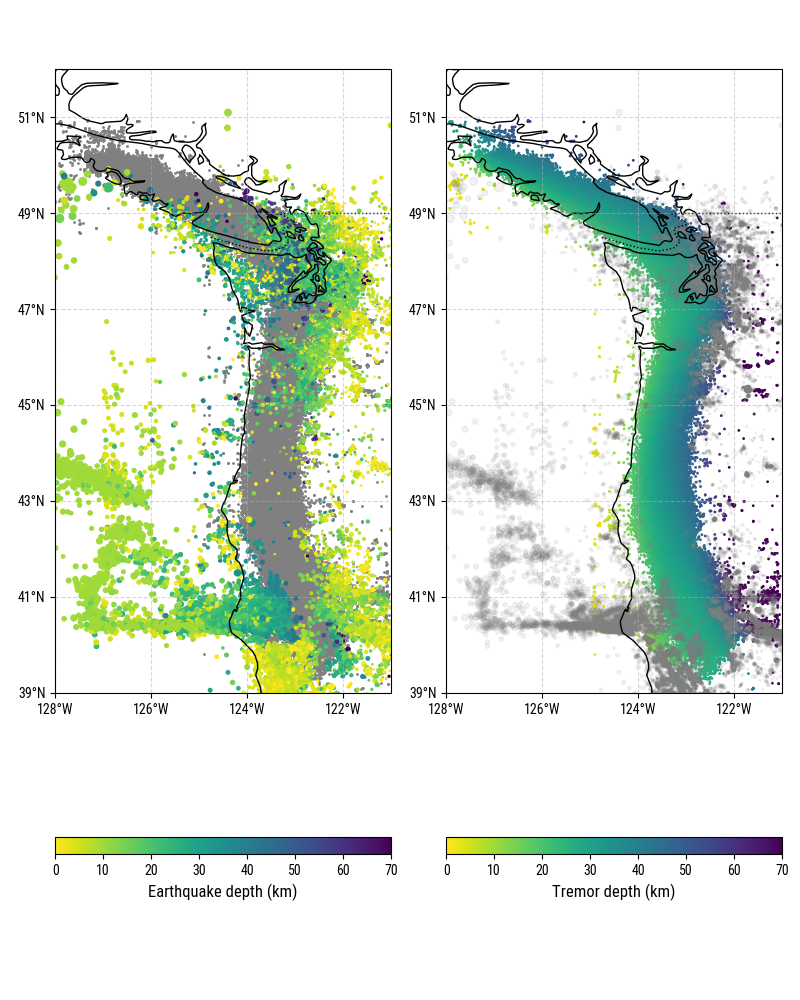

In [141]:
# Plot it
fig = plt.figure(figsize=(8, 10))
axes = [fig.add_subplot(121, projection=ccrs.PlateCarree()), fig.add_subplot(122, projection=ccrs.PlateCarree())]

for ax in axes:
    ax.set_extent([minlon, maxlon, minlat, maxlat])
    ax.coastlines(resolution='50m')
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # grid and labels, only bottom and left, not top and right
    ax.set_xticks(np.arange(minlon, maxlon, 2))
    ax.set_yticks(np.arange(minlat, maxlat, 2))
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.grid('on', linestyle='--', alpha=0.5)


# Plot earthquakes and tremor
sc = axes[0].scatter(eq.lon, eq.lat, s=eq.mag**2, c=eq.depth, cmap='viridis_r', transform=ccrs.PlateCarree(), vmin=0, vmax=70)
axes[0].scatter(trm.lon, trm.lat, s=1, c='.5', transform=ccrs.PlateCarree(), zorder=-1)
cbar = plt.colorbar(sc, ax=axes[0], orientation='horizontal', label='Earthquake depth (km)')

axes[1].scatter(eq.lon, eq.lat, s=eq.mag**2, c=to_rgba('.5', .1),transform=ccrs.PlateCarree())
sc = axes[1].scatter(trm.lon, trm.lat, s=1, c=trm.depth, transform=ccrs.PlateCarree(), zorder=-1, cmap='viridis_r', vmin=0, vmax=70)
cbar = plt.colorbar(sc, ax=axes[1], orientation='horizontal', label='Tremor depth (km)')

plt.tight_layout()
plt.show()

# 3. <a id='toc3_'></a>Count number of earthquakes that can trigger tremor   [&#128285;](#toc0_)

In [149]:
compute = True

In [143]:
# Which earthquakes should count
interval = [np.datetime64('2009-09-01'), np.datetime64('2024-06-01')]
min_mag = 1.5  # Mc~1.5
selected_eq = eq[(eq.date.values >= interval[0]) & (eq.date.values <= interval[1]) & (eq.mag >= min_mag)]

## 3.1. <a id='toc3_1_'></a>Count earthquakes at given distance [&#128285;](#toc0_)

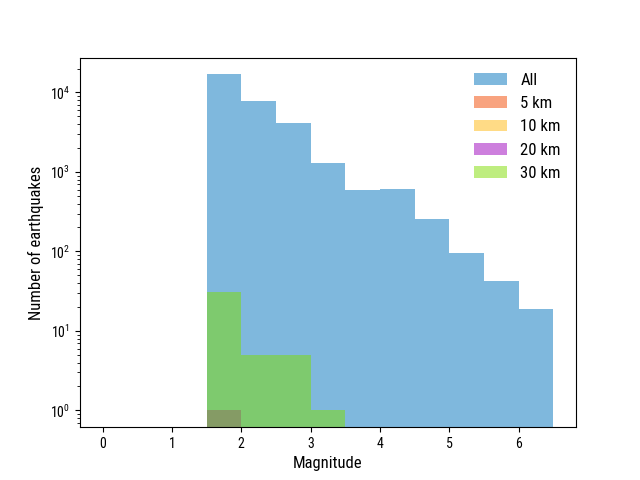

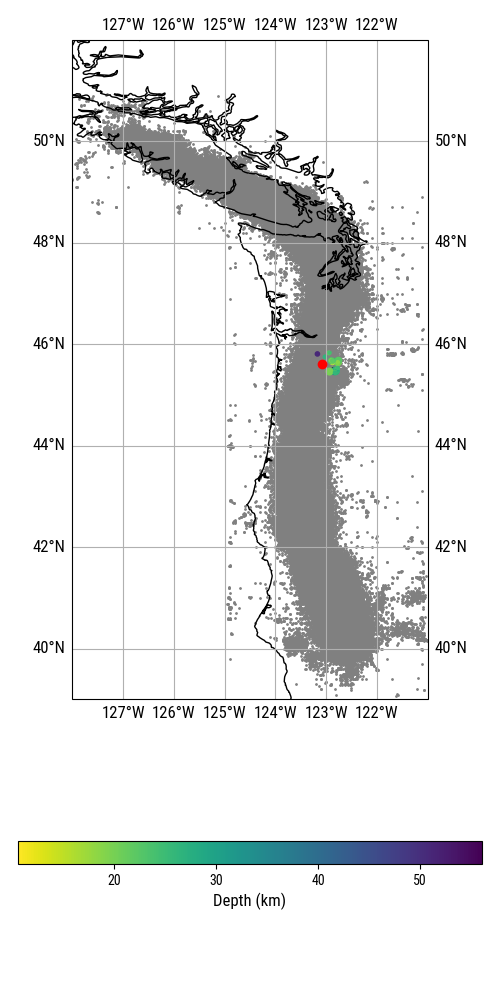

In [147]:
# For one tremor
tremor = trm.iloc[2]
distances = distance(selected_eq.lon.values, selected_eq.lat.values, selected_eq.depth.values, tremor.lon, tremor.lat, tremor.depth)

eq_5km = distances < 5
eq_10km = distances < 10
eq_20km = distances < 20
eq_30km = distances < 30

fig, ax = plt.subplots()
ax.set_xlabel('Magnitude')
ax.set_ylabel('Number of earthquakes')
ax.hist(selected_eq.mag, bins=np.arange(0, 7, .5), alpha=.5, label='All')
ax.hist(selected_eq.mag[eq_5km], bins=np.arange(0, 7, .5), alpha=.5, label='5 km')
ax.hist(selected_eq.mag[eq_10km], bins=np.arange(0, 7, .5), alpha=.5, label='10 km')
ax.hist(selected_eq.mag[eq_20km], bins=np.arange(0, 7, .5), alpha=.5, label='20 km')
ax.hist(selected_eq.mag[eq_30km], bins=np.arange(0, 7, .5), alpha=.5, label='30 km')
ax.legend()
ax.set_yscale('log')
plt.show()

fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([minlon, maxlon, minlat, maxlat])
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='black')

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

ax.scatter(trm.lon, trm.lat, s=1, c='.5', transform=ccrs.PlateCarree())
ax.plot(tremor.lon, tremor.lat, 'ro', transform=ccrs.PlateCarree())

indicator = eq_30km

sc = ax.scatter(selected_eq.lon[indicator], selected_eq.lat[indicator], s=selected_eq.mag[indicator]**3, c=selected_eq.depth[indicator], transform=ccrs.PlateCarree(), alpha=1, cmap='viridis_r')
plt.colorbar(sc, label='Depth (km)', orientation='horizontal')

plt.tight_layout()
plt.show()

In [152]:
# Compute number of earthquakes at stressing distance for each tremor
if compute:
    n_5km = np.zeros(trm.shape[0])
    n_10km = np.zeros(trm.shape[0])
    n_20km = np.zeros(trm.shape[0])
    n_30km = np.zeros(trm.shape[0])

    eq_5km = np.zeros(selected_eq.shape[0], dtype=bool)
    eq_10km = np.zeros(selected_eq.shape[0], dtype=bool)
    eq_20km = np.zeros(selected_eq.shape[0], dtype=bool)
    eq_30km = np.zeros(selected_eq.shape[0], dtype=bool)

    subset_size = 100  # Number of tremors to process at once
    ii = 0
    while ii < trm.shape[0]:
        print(f'Tremor sample {ii}/{trm.shape[0]}', end='\r')
        # Subset
        lons = trm.lon.values[ii:ii+subset_size]
        lats = trm.lat.values[ii:ii+subset_size]
        depths = trm.depth.values[ii:ii+subset_size]

        # Compute distances (dim (subset_size, n_eq))
        distances = distance(lats[:, np.newaxis], lons[:, np.newaxis], depths[:, np.newaxis], selected_eq.lat.values, selected_eq.lon.values, selected_eq.depth.values)
        dist5 = distances < 5.
        dist10 = distances < 10.
        dist20 = distances < 20.
        dist30 = distances < 30.

        # Count number of earthqakes (dim (subset_size, ))
        n_5km[ii:ii+subset_size] = dist5.sum(axis=1)
        n_10km[ii:ii+subset_size] = dist10.sum(axis=1)
        n_20km[ii:ii+subset_size] = dist20.sum(axis=1)
        n_30km[ii:ii+subset_size] = dist30.sum(axis=1)

        # Select earthquakes
        eq_5km = dist5.any(axis=0) | eq_5km
        eq_10km = dist10.any(axis=0) | eq_10km
        eq_20km = dist20.any(axis=0) | eq_20km
        eq_30km = dist30.any(axis=0) | eq_30km

        # Update ii
        ii = ii + subset_size

In [155]:
# Save it
if compute:
    print('Saving it...')
    trm['n_5km'] = n_5km
    trm['n_10km'] = n_10km
    trm['n_20km'] = n_20km
    trm['n_30km'] = n_30km

    trm.to_csv('data/cascadia/processed/casc_trm_0809_0624_zb19_dist.csv', index=False, columns=['date', 'lat', 'lon', 'depth', 'n_5km', 'n_10km', 'n_20km', 'n_30km'])

    selected_eq['eq_5km'] = eq_5km
    selected_eq['eq_10km'] = eq_10km
    selected_eq['eq_20km'] = eq_20km
    selected_eq['eq_30km'] = eq_30km

    selected_eq.to_csv('data/cascadia/processed/casc_eqmc{:.1f}_0809_0624_dist.csv'.format(min_mag), index=False, columns=['date', 'lat', 'lon', 'depth', 'mag', 'eq_5km', 'eq_10km', 'eq_20km', 'eq_30km'])

Saving it...


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_30181/2404000267.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_eq['eq_5km'] = eq_5km
/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_30181/2404000267.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_eq['eq_10km'] = eq_10km
/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_30181/2404000267.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

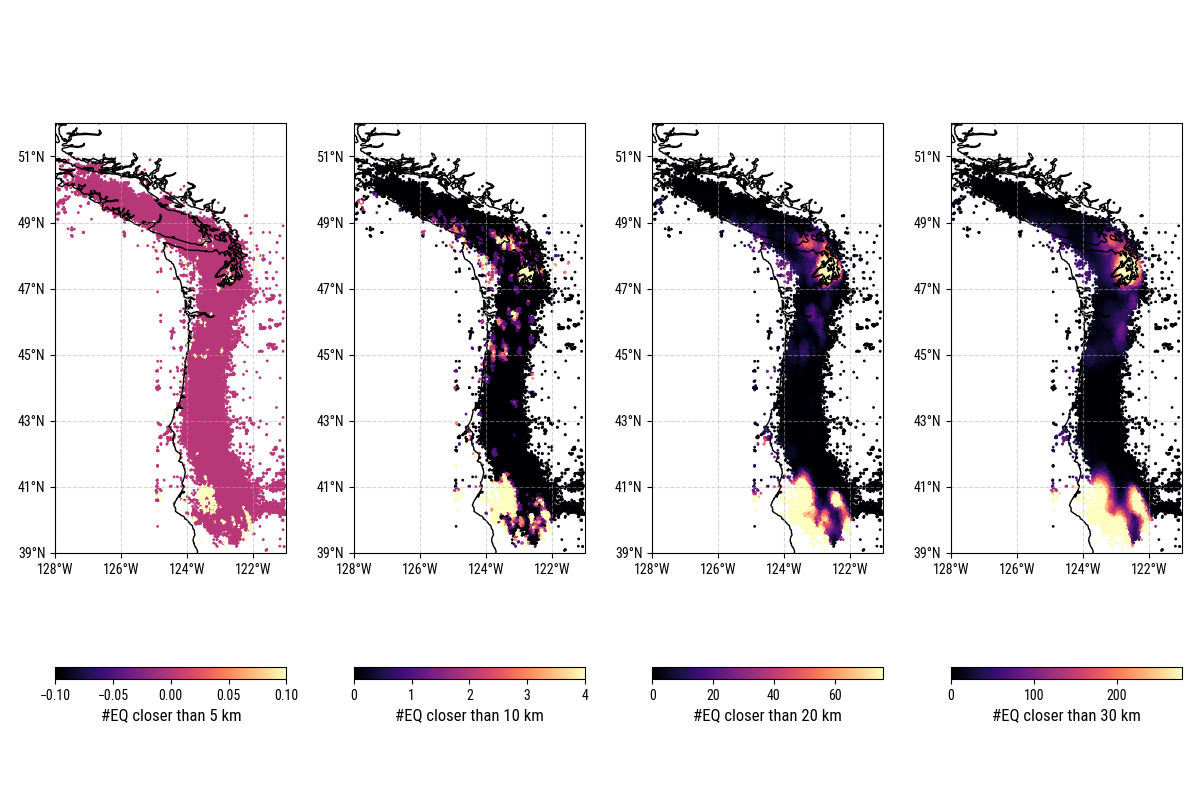

In [154]:
# Show it
fig = plt.figure(figsize=(12, 8))
crs = ccrs.PlateCarree()
axes = [plt.subplot(1, 4, ii+1, projection=crs) for ii in range(4)]

for d, ax in zip([5, 10, 20, 30], axes):
    # Plot tremor
    sc = ax.scatter(trm.lon, trm.lat, c=trm['n_{:d}km'.format(d)], s=1, cmap='magma', transform=crs, vmin=0, vmax=np.percentile(trm['n_{:d}km'.format(d)], 95))
    cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', label='#EQ closer than {:d} km'.format(d))

    ax.set_extent([minlon, maxlon, minlat, maxlat], crs=crs)
    ax.coastlines(lw=1)

    # grid and labels, only bottom and left, not top and right
    ax.set_xticks(np.arange(minlon, maxlon, 2), crs=crs)
    ax.set_yticks(np.arange(minlat, maxlat, 2), crs=crs)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.grid('on', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


## 3.2. <a id='toc3_2_'></a>Count earthquakes at magnitude dependent distance [&#128285;](#toc0_)

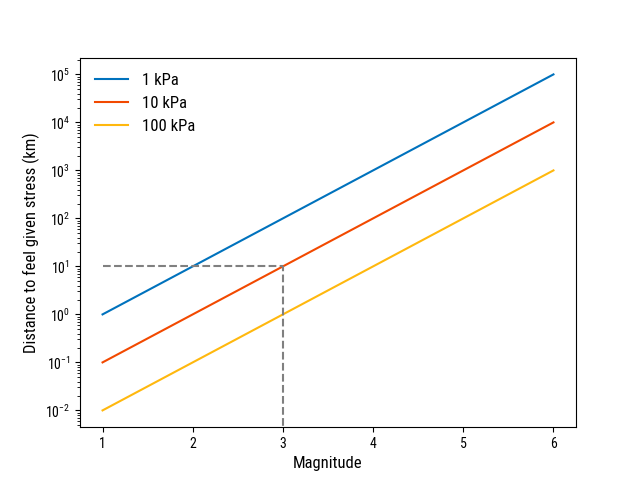

In [123]:
# Distance for a given stress function
ref_mag = 3
ref_dist = 10  # km
ref_stress = 10  # kPa
C = ref_stress * ref_dist * 10**(-ref_mag)

def dist_stress(mag, stress):
    return C / stress * 10**mag

# Show what it looks like
mags = np.linspace(1, 6, 100)
stresses = [1, 10, 100]

fig, ax = plt.subplots()
ax.set_xlabel('Magnitude')
ax.set_ylabel('Distance to feel given stress (km)')
ax.set_yscale('log')
for stress in stresses:
    ax.plot(mags, dist_stress(mags, stress), label=f'{stress} kPa')
ax.legend()

ax.plot([mags.min(), ref_mag], [ref_dist, ref_dist], linestyle='--', c='.5')
ax.plot([ref_mag, ref_mag], [0, ref_dist], linestyle='--', c='.5')

plt.show()

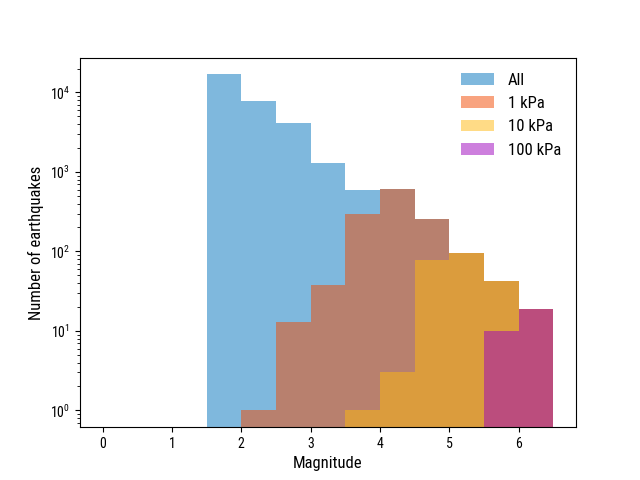

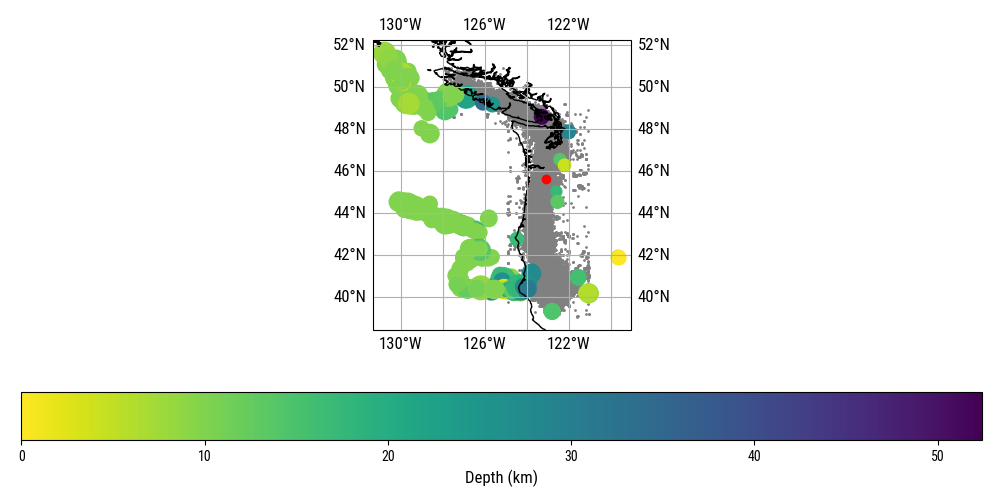

In [125]:
# For one tremor
tremor = trm.iloc[2]
distances = distance(selected_eq.lon.values, selected_eq.lat.values, selected_eq.depth.values, tremor.lon, tremor.lat, tremor.depth)

eq_1kPa = distances < dist_stress(selected_eq.mag, 1)
eq_10kPa = distances < dist_stress(selected_eq.mag, 10)
eq_100kPa = distances < dist_stress(selected_eq.mag, 100)

fig, ax = plt.subplots()
ax.set_xlabel('Magnitude')
ax.set_ylabel('Number of earthquakes')
ax.hist(selected_eq.mag, bins=np.arange(0, 7, .5), alpha=.5, label='All')
ax.hist(selected_eq.mag[eq_1kPa], bins=np.arange(0, 7, .5), alpha=.5, label='1 kPa')
ax.hist(selected_eq.mag[eq_10kPa], bins=np.arange(0, 7, .5), alpha=.5, label='10 kPa')
ax.hist(selected_eq.mag[eq_100kPa], bins=np.arange(0, 7, .5), alpha=.5, label='100 kPa')
ax.legend()
ax.set_yscale('log')
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
# ax.set_extent([131, 139, 32.5, 35.5], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='black')

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

ax.scatter(trm.lon, trm.lat, s=1, c='.5', transform=ccrs.PlateCarree())
ax.plot(tremor.lon, tremor.lat, 'ro', transform=ccrs.PlateCarree())

indicator = eq_10kPa

sc = ax.scatter(selected_eq.lon[indicator], selected_eq.lat[indicator], s=selected_eq.mag[indicator]**3, c=selected_eq.depth[indicator], transform=ccrs.PlateCarree(), alpha=1, cmap='viridis_r')
plt.colorbar(sc, label='Depth (km)', orientation='horizontal')

plt.tight_layout()
plt.show()

In [127]:
# # Compute number of earthquakes at stressing distance for each tremor
# if compute:
#     n_1kPa = np.zeros(trm.shape[0])
#     n_10kPa = np.zeros(trm.shape[0])
#     n_100kPa = np.zeros(trm.shape[0])

#     subset_size = 1000  # Number of tremors to process at once
#     ii = 0
#     while ii < trm.shape[0]:
#         print(f'Tremor sample {ii}/{trm.shape[0]}', end='\r')
#         # Subset
#         lons = trm.lon.values[ii:ii+subset_size]
#         lats = trm.lat.values[ii:ii+subset_size]
#         depths = trm.depth.values[ii:ii+subset_size]

#         # Compute distances (dim (subset_size, n_eq))
#         distances = distance(lats[:, np.newaxis], lons[:, np.newaxis], depths[:, np.newaxis], selected_eq.lat.values, selected_eq.lon.values, selected_eq.depth.values)

#         # Count number of earthqakes (dim (subset_size, ))
#         n_1kPa[ii:ii+subset_size] = (distances < dist_stress(selected_eq.mag.values, 1)).sum(axis=1)
#         n_10kPa[ii:ii+subset_size] = (distances < dist_stress(selected_eq.mag.values, 10)).sum(axis=1)
#         n_100kPa[ii:ii+subset_size] = (distances < dist_stress(selected_eq.mag.values, 100)).sum(axis=1)

#         # Update ii
#         ii = ii + subset_size

In [117]:
# # Save it
# if compute:
#     print('Saving it...')
#     trm['n_1kPa'] = n_1kPa
#     trm['n_10kPa'] = n_10kPa
#     trm['n_100kPa'] = n_100kPa

#     trm.to_csv('data/cascadia/processed/casc_trm_0809_0624_zb19_stress.csv', columns=['date', 'lat', 'lon', 'depth', 'n_1kPa', 'n_10kPa', 'n_100kPa'], index=False)

Saving it...


In [118]:
# Load it
if not compute:
    print('Loading it...')
    trm = pd.read_csv('data/cascadia/processed/casc_trm_0809_0624_zb19_stress.csv', parse_dates=['date'])

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_30181/1666548906.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(3, 1, figsize=(6, 8))


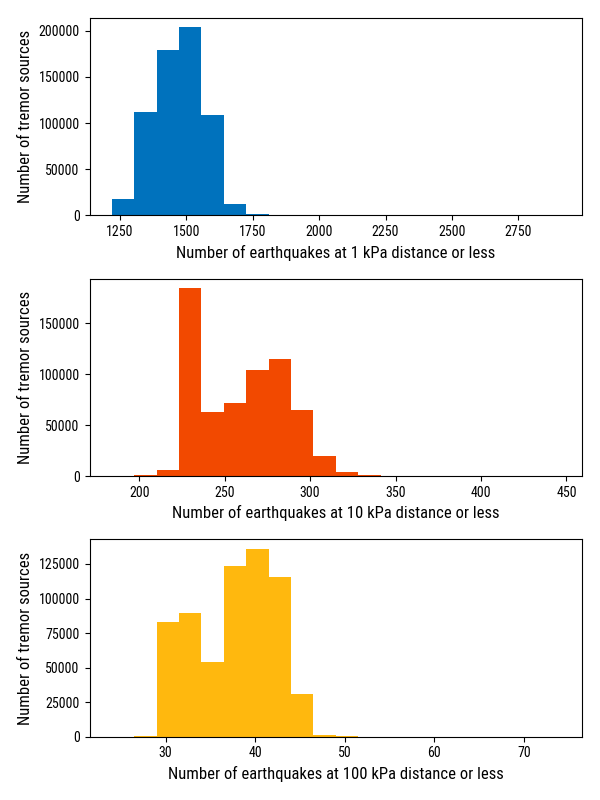

In [119]:
# Histograms
fig, axes = plt.subplots(3, 1, figsize=(6, 8))
axes[0].hist(n_1kPa, bins=20, color='C0')
axes[0].set_xlabel('Number of earthquakes at 1 kPa distance or less')
axes[0].set_ylabel('Number of tremor sources')

axes[1].hist(n_10kPa, bins=20, color='C1')
axes[1].set_xlabel('Number of earthquakes at 10 kPa distance or less')
axes[1].set_ylabel('Number of tremor sources')

axes[2].hist(n_100kPa, bins=20, color='C2')
axes[2].set_xlabel('Number of earthquakes at 100 kPa distance or less')
axes[2].set_ylabel('Number of tremor sources')

plt.tight_layout()
plt.show()


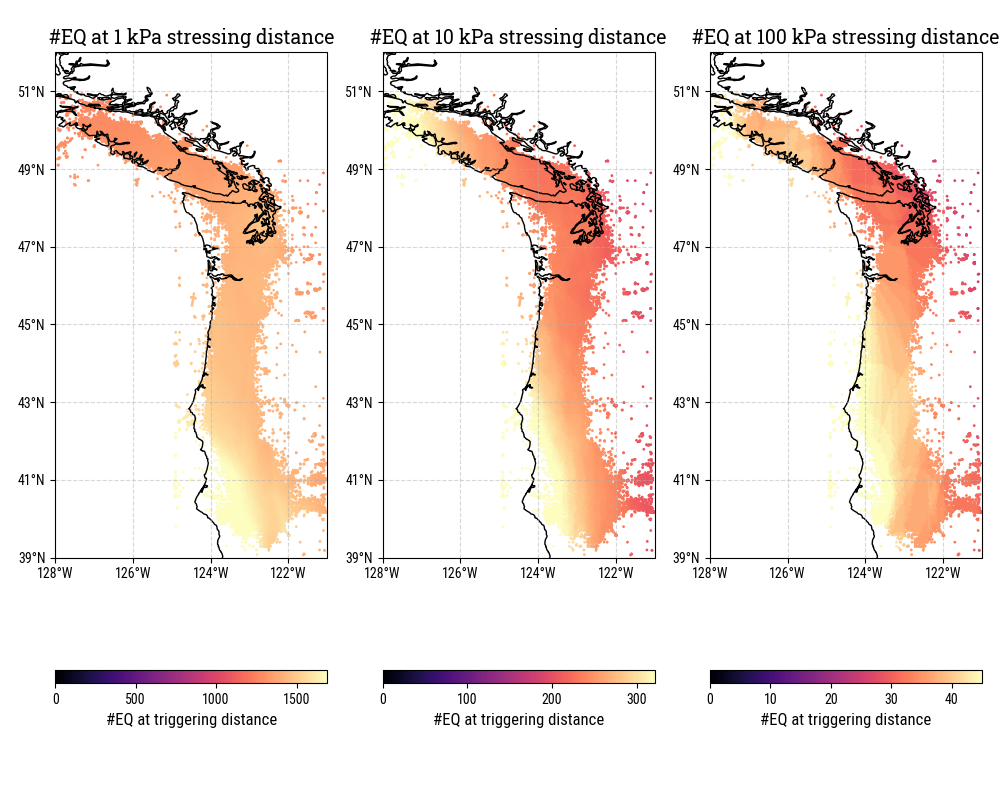

In [120]:
# Show them in space
fig = plt.figure(figsize=(10, 8))
crs = ccrs.PlateCarree()
axes = [plt.subplot(131, projection=crs), plt.subplot(132, projection=crs), plt.subplot(133, projection=crs)]
titles = ['#EQ at 1 kPa stressing distance', '#EQ at 10 kPa stressing distance', '#EQ at 100 kPa stressing distance']
stressing_distances = [n_1kPa, n_10kPa, n_100kPa]

for ii, ax in enumerate(axes):
    # Plot tremor
    sc = ax.scatter(trm.lon, trm.lat, c=stressing_distances[ii], s=1, cmap='magma', transform=crs, vmin=0, vmax=np.percentile(stressing_distances[ii], 99.5))
    cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', label='#EQ at triggering distance')

    # Plot earthquakes
    # ax.scatter(selected_eq.lon, selected_eq.lat, c=to_rgba('k', .2), s=selected_eq.mag**2, transform=crs)

    ax.set_title(titles[ii], fontname='Roboto Slab', fontsize=14)
    ax.set_extent([minlon, maxlon, minlat, maxlat], crs=crs)
    ax.coastlines(lw=1)

    # grid and labels, only bottom and left, not top and right
    ax.set_xticks(np.arange(minlon, maxlon, 2), crs=crs)
    ax.set_yticks(np.arange(minlat, maxlat, 2), crs=crs)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.grid('on', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
